Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

# Setup

In [3]:
!conda install ipykernel --name py365

Solving environment: ...working... done

# All requested packages already installed.





==> WARNING: A newer version of conda exists. <==
  current version: 4.4.6
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base conda




In [4]:
!python -m ipykernel install

Installed kernelspec python3 in C:\ProgramData\jupyter\kernels\python3


In [1]:
%gui qt5 

In [2]:
# Imports in alphabetical order of module name

from IPython.display import display
from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt


# Load images

## Segmentation channel (Ndnf)

In [3]:
## Specify images to load

folder = 'Z:\HCR\HCR_9.13\S2_546_647_dapi_514_z-stack_tiles_2019_09_17__00_55_58'

base_filename = 'S2_546_647_dapi_514_z-stack_tiles_2019_09_17__00_55_58_z'

plane_nos = range(1, 19)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

Number of planes: 18


In [4]:
# Create 4D array to store images
img = Image.open('{0}\{1}{2}c1_ORG.tif'.format(folder, base_filename, str(plane_nos[0]).zfill(2)))

h = img.height
                  
w = img.width
                  
im_array = np.zeros([n, h, w])
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c1_ORG.tif'.format(folder, base_filename, str(p).zfill(2)))
    try:
        im_array[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue


Size of image in pixels: 18 X 2354 X 6501
Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


## Channels to measure (Npy + Egln3)

### Without background subtraction

In [46]:
im_array_egln3 = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c2_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_egln3[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_egln3 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


In [47]:
im_array_npy = np.zeros([n, h, w])
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}{2}c4_ORG.tif'.format(folder, base_filename,str(p).zfill(2)))
    try:
        im_array_npy[i, :, :] = np.array(img)
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_npy = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


### With background subtraction

In [7]:
im_array_egln3 = np.zeros([n, h, w])
img_file = 's2_c2_647_egln3_background_subtracted'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_egln3[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_egln3 = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


In [8]:
im_array_npy = np.zeros([n, h, w])
img_file = 's2_c4_514_npy_background_subtracted'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    try:
        img.seek(p - 1)
        im_array_npy[i, :, :] = np.array(img)
        
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array_npy = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)
        continue

Loading image 1
Loading image 2
Loading image 3
Loading image 4
Loading image 5
Loading image 6
Loading image 7
Loading image 8
Loading image 9
Loading image 10
Loading image 11
Loading image 12
Loading image 13
Loading image 14
Loading image 15
Loading image 16
Loading image 17
Loading image 18


# Annotation

## Data structure to store information about cells

In [5]:
class Cell:
    n_cells = 1
    cell_data = {}
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(1)
        print('Cell #{0} created'.format(Cell.n_cells))
        Cell.n_cells += 1
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        Cell.cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}

## Load masks if they already exist

In [9]:
save_loc = 'Z:\HCR\HCR_9.13'
save_file = 'S2_data.pkl'
try:
    with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
        Cell.cell_data = pkl.load(f)
        indices = list(Cell.cell_data.keys())
        if not np.max(indices) == len(indices):
            print('Re-numbering cells to be consecutive')
            Cell.cell_data_temp = {}
            for i in range(len(indices)):
                Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
                Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
            Cell.cell_data = Cell.cell_data_temp 
            with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)
    Cell.n_cells = len(indices)
    print('{0} cells found'.format(Cell.n_cells))
except:
    Cell.cell_data = {}
    print('No data found')

200 cells found


## Render image in napari GUI

In [14]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

viewer.add_image(im_array[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 0
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Add existing masks
indices = list(Cell.cell_data.keys())
mask_layer = viewer.layers['masks']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Keybinding functions

@viewer.bind_key('n')
def new_cell(viewer):
    global cell1 
    cell1 = Cell(Cell.n_cells)

@viewer.bind_key('m')
def add_mask(viewer):
    seg_layer = viewer.layers[seg_channel]
    z_plane = seg_layer.coordinates[0]
    mask = viewer.layers['masks'].data[-1]
    cell1.add_mask(z_plane, mask)
    
@viewer.bind_key('k')
def save_cell(viewer):
    cell1.save_cell()
    
@viewer.bind_key('Control-s')
def save_all(viewer):
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)
            
@viewer.bind_key('Control-d')
def delete_cell(viewer, cell_id):
    Cell.cell_data.pop()

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


## View masks created

In [42]:
Cell.cell_data[list(Cell.cell_data.keys())[-1]]

{'cell_id': 200,
 'z_planes': [16, 17],
 'masks': {16: array([[ 897.25981886, 5836.3486942 ],
         [ 888.11321337, 5840.22907228],
         [ 883.12415583, 5844.6637901 ],
         [ 879.52094761, 5850.48435723],
         [ 880.62962706, 5857.96794354],
         [ 882.84698597, 5859.90813258],
         [ 889.49906269, 5861.2939819 ],
         [ 893.37944077, 5860.18530244],
         [ 896.70547913, 5855.75058463],
         [ 903.08038599, 5851.31586682],
         [ 907.23793394, 5846.32680928],
         [ 916.10736957, 5842.16926133],
         [ 912.50416134, 5832.74548597],
         [ 906.68359421, 5829.69661748],
         [ 903.35755585, 5831.35963666],
         [ 900.86302708, 5833.02265584]]),
  17: array([[ 884.78717501, 5842.72360105],
         [ 880.07528733, 5852.70171613],
         [ 881.46113665, 5857.69077367],
         [ 886.45019419, 5859.07662299],
         [ 890.33057228, 5858.52228326],
         [ 896.15113941, 5856.02775449],
         [ 901.14019695, 5849.9300175 ]

In [43]:
len(Cell.cell_data.keys())

200

In [31]:
cell1.masks

{11: array([[ 647.01398991, 2288.55198964],
        [ 650.2968341 , 2297.30624083],
        [ 654.30919923, 2301.50098619],
        [ 658.13918412, 2301.86574666],
        [ 661.96916902, 2300.58908503],
        [ 664.88725275, 2298.58290246],
        [ 668.17009694, 2294.75291757],
        [ 668.71723764, 2289.64627104],
        [ 667.80533647, 2286.72818731],
        [ 665.43439344, 2284.53962452],
        [ 659.59822599, 2282.53344195],
        [ 653.76205853, 2282.35106172],
        [ 650.47921433, 2282.16868149],
        [ 649.02017247, 2283.44534312],
        [ 649.02017247, 2283.44534312]]),
 12: array([[ 646.64922944, 2290.92293267],
        [ 644.64304688, 2296.5767199 ],
        [ 646.83160967, 2300.58908503],
        [ 650.11445387, 2301.86574666],
        [ 652.85015736, 2300.77146526],
        [ 657.04490272, 2300.04194433],
        [ 662.33392948, 2298.218142  ],
        [ 665.06963298, 2299.31242339],
        [ 667.98771671, 2300.22432456],
        [ 671.8177016 , 2300.7

## Manual segmentation

In [16]:
Cell.n_cells

36

In [85]:
if Cell.n_cells > 1:
    cell1.save_cell()
    print('Cell {0} saved'.format(cell1.cell_no))
cell1 = Cell(Cell.n_cells)

Cell 21 saved
Cell #22 created


In [87]:
seg_layer = viewer.layers[seg_channel]
z_plane = seg_layer.coordinates[0]


mask = viewer.layers['masks'].data[-1]
cell1.add_mask(z_plane, mask)
print('mask {0} added in z-plane {1} for cell {2}'.format(cell1.no_planes, z_plane, cell1.cell_no))

mask 2 added in z-plane 11 for cell 22


In [88]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(cell_data, f)

## Calculate intensity in other channels

In [10]:
# Only run once:
xv = range(w)
yv = range(h)
coord_array = np.array(np.meshgrid(xv, yv))

points = np.zeros([h*w, 2])
p = 0
for i in range(h):
    for j in range(w):
        points[p, 1] = coord_array[0, i, j]
        points[p, 0] = coord_array[1, i, j]
        p += 1

In [11]:
# ~8 min for 200 cells
no_cells = len(Cell.cell_data.keys())
avg_intensity_egln3 = np.zeros(no_cells)
avg_intensity_npy = np.zeros(no_cells)

for cell in range(no_cells):
    
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    masks = cell_dict['masks']
    z_planes = cell_dict['z_planes']

    intensity_egln3 = np.zeros(cell_dict['no_planes'])
    intensity_npy = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        vertices = masks[plane]
        path = mpltpath.Path(vertices)
        mask = path.contains_points(points)
        mask = np.reshape(mask, [h, w])

        intensity_egln3[i] = np.mean(im_array_egln3[plane, mask])
        intensity_npy[i] = np.mean(im_array_npy[plane, mask])
        i += 1
    
    avg_intensity_egln3[cell] = np.mean(intensity_egln3)
    avg_intensity_npy[cell] = np.mean(intensity_npy)


Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50
Cell 60
Cell 70
Cell 80
Cell 90
Cell 100
Cell 110
Cell 120
Cell 130
Cell 140
Cell 150
Cell 160
Cell 170
Cell 180
Cell 190


(array([ 7., 75., 69., 26.,  6.,  3.,  5.,  1.,  1.,  0.,  1.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00540071, 0.02529269, 0.04518468, 0.06507666, 0.08496865,
        0.10486064, 0.12475262, 0.14464461, 0.16453659, 0.18442858,
        0.20432057, 0.22421255, 0.24410454, 0.26399652, 0.28388851,
        0.30378049, 0.32367248, 0.34356447, 0.36345645, 0.38334844,
        0.40324042, 0.42313241, 0.4430244 , 0.46291638, 0.48280837,
        0.50270035, 0.52259234, 0.54248433, 0.56237631, 0.5822683 ,
        0.60216028, 0.62205227, 0.64194425, 0.66183624, 0.68172823,
        0.70162021, 0.7215122 , 0.74140418, 0.76129617, 0.78118816,
        0.80108014, 0.82097213, 0.84086411, 0.8607561 , 0.88064808,
        0.90054007, 0.92043206, 0.94032404, 0.96021603, 0.98010801,
        1.        ]),
 <a list of 50

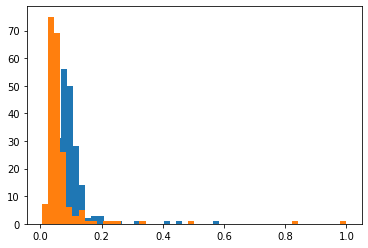

In [12]:
plt.hist(avg_intensity_egln3/np.nanmax(avg_intensity_egln3), 50)
plt.hist(avg_intensity_npy/np.nanmax(avg_intensity_npy), 50)

In [836]:
avg_intensity

array([24.95022124, 40.51698552, 29.09375251, 29.70655193, 34.28772759,
       26.79298246, 32.11151902, 36.66856214, 31.12916451, 30.94487015,
       31.73982033, 43.42839613, 32.75322324, 35.283061  , 51.98990961,
       31.53225302, 40.76069519, 41.11062645, 40.17823601, 37.93169793,
       53.76939491, 42.54205998, 38.89276079, 35.80030759, 29.70721714,
       31.29138233, 26.49753248, 33.4169647 , 48.89624381, 35.60775862,
       37.37936089, 40.91992248, 38.84522526, 39.96567944, 38.72161887,
       36.22450535, 31.1216872 , 32.1789749 , 37.56818182, 31.7029703 ,
       25.12078545, 31.4352518 , 32.83067422, 29.86585859, 28.95391335,
       25.38526056, 25.26495726, 17.05158859, 32.95391705, 29.29847772,
       27.65829146, 29.2310909 , 29.20095163, 26.92653061, 24.15262701,
       27.38459205, 23.84102183, 27.70256569, 28.7169158 , 27.32855492,
       24.42166442, 29.33239191, 37.91411043, 29.01273972, 22.71582282,
       29.10530973, 25.72648526, 31.79910714, 31.79378318, 36.26

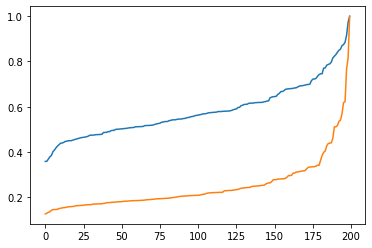

In [77]:
plt.plot(np.sort(avg_intensity_egln3)/np.nanmax(avg_intensity_egln3))
plt.plot(np.sort(avg_intensity_npy)/np.nanmax(avg_intensity_npy))

In [14]:
%matplotlib qt

In [16]:
plt.scatter(avg_intensity_egln3/np.max(avg_intensity_egln3), avg_intensity_npy/np.max(avg_intensity_npy), color = 'k', marker = 'o',
           alpha = 0.2)


plt.xlabel('Relative expression of Egln3')
plt.ylabel('Relative expression of Npy')

Text(0, 0.5, 'Relative expression of Npy')

(array([[1., 2., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.35785613, 0.37069901, 0.38354188, 0.39638476, 0.40922764,
        0.42207052, 0.43491339, 0.44775627, 0.46059915, 0.47344203,
        0.4862849 , 0.49912778, 0.51197066, 0.52481354, 0.53765641,
        0.55049929, 0.56334217, 0.57618505, 0.58902792, 0.6018708 ,
        0.61471368, 0.62755655, 0.64039943, 0.65324231, 0.66608519,
        0.67892806, 0.69177094, 0.70461382, 0.7174567 , 0.73029957,
        0.74314245, 0.75598533, 0.76882821, 0.78167108, 0.79451396,
        0.80735684, 0.82019972, 0.83304259, 0.84588547, 0.85872835,
        0.87157123, 0.8844141 , 0.89725698, 0.91009986, 0.92294274,
        0.93578561, 0.94862849, 0.96147137, 0.97431425, 0.98715712,
        1.        ]),
 array([0.12564018, 0.14312737, 0.16061457, 0.178

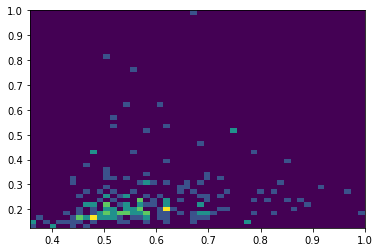

In [82]:
plt.hist2d(avg_intensity_egln3/np.max(avg_intensity_egln3), avg_intensity_npy/np.max(avg_intensity_npy), bins = 50)

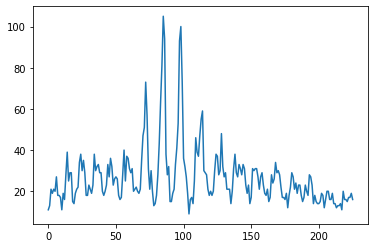

In [801]:
plt.plot(layer.data[plane, mask])

(0, 100)

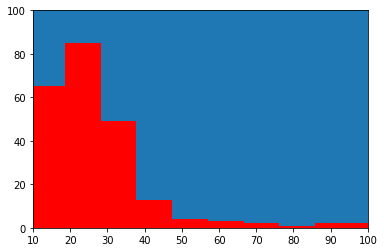

In [807]:
fig = plt.figure()
plt.hist(np.reshape(layer.data[plane, :, :], [-1]), 100)
plt.hist(layer.data[plane, mask], color = 'r')
plt.xlim(10, 100)
plt.ylim(0, 100)

In [806]:
layer.data[plane, mask]

array([ 11.,  13.,  21.,  19.,  21.,  20.,  27.,  18.,  18.,  17.,  11.,
        19.,  16.,  28.,  39.,  25.,  29.,  29.,  15.,  14.,  19.,  21.,
        22.,  34.,  38.,  30.,  35.,  29.,  18.,  18.,  23.,  21.,  19.,
        23.,  38.,  30.,  32.,  33.,  29.,  29.,  20.,  18.,  20.,  23.,
        33.,  27.,  36.,  32.,  23.,  26.,  27.,  26.,  18.,  16.,  17.,
        28.,  40.,  25.,  37.,  36.,  31.,  29.,  31.,  20.,  21.,  22.,
        20.,  19.,  21.,  35.,  47.,  51.,  73.,  57.,  31.,  21.,  30.,
        20.,  13.,  14.,  18.,  28.,  43.,  63.,  81., 105.,  94.,  38.,
        28.,  32.,  15.,  15.,  19.,  21.,  33.,  41.,  53.,  93., 100.,
        73.,  36.,  32.,  27.,  19.,   9.,  16.,  17.,  14.,  25.,  46.,
        39.,  37.,  47.,  55.,  59.,  30.,  29.,  28.,  21.,  18.,  20.,
        18.,  20.,  30.,  38.,  37.,  28.,  30.,  48.,  32.,  27.,  29.,
        21.,  21.,  21.,  14.,  20.,  31.,  38.,  29.,  27.,  33.,  31.,
        28.,  33.,  31.,  23.,  19.,  23.,  14.,  1

# View saved masks

In [74]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(Cell.cell_data, f)

In [49]:
indices = list(Cell.cell_data.keys())
Cell.cell_data[indices[-1]]

{'cell_id': 200,
 'z_planes': [16, 17],
 'masks': {16: array([[ 897.25981886, 5836.3486942 ],
         [ 888.11321337, 5840.22907228],
         [ 883.12415583, 5844.6637901 ],
         [ 879.52094761, 5850.48435723],
         [ 880.62962706, 5857.96794354],
         [ 882.84698597, 5859.90813258],
         [ 889.49906269, 5861.2939819 ],
         [ 893.37944077, 5860.18530244],
         [ 896.70547913, 5855.75058463],
         [ 903.08038599, 5851.31586682],
         [ 907.23793394, 5846.32680928],
         [ 916.10736957, 5842.16926133],
         [ 912.50416134, 5832.74548597],
         [ 906.68359421, 5829.69661748],
         [ 903.35755585, 5831.35963666],
         [ 900.86302708, 5833.02265584]]),
  17: array([[ 884.78717501, 5842.72360105],
         [ 880.07528733, 5852.70171613],
         [ 881.46113665, 5857.69077367],
         [ 886.45019419, 5859.07662299],
         [ 890.33057228, 5858.52228326],
         [ 896.15113941, 5856.02775449],
         [ 901.14019695, 5849.9300175 ]

In [50]:
cell1.masks

{13: array([[ 803.19646004, 1472.81437592],
        [ 809.34684968, 1483.06502532],
        [ 817.88905751, 1488.87372664],
        [ 824.38113546, 1485.1151552 ],
        [ 826.77295366, 1480.33151881],
        [ 829.50646016, 1476.23125905],
        [ 829.16477185, 1470.76424604],
        [ 822.33100558, 1467.68905122],
        [ 813.78879775, 1467.0056746 ],
        [ 807.2967198 , 1467.34736291],
        [ 803.19646004, 1467.68905122],
        [ 801.82970679, 1468.03073954]]),
 14: array([[ 811.05529125, 1461.8803499 ],
        [ 807.2967198 , 1467.68905122],
        [ 803.87983667, 1474.18112917],
        [ 809.68853799, 1484.09009026],
        [ 815.15555101, 1486.14022014],
        [ 818.23074583, 1486.14022014],
        [ 823.01438221, 1482.38164869],
        [ 826.08957703, 1478.62307725],
        [ 826.77295366, 1467.0056746 ],
        [ 824.03944715, 1461.53866158],
        [ 820.62256402, 1459.14684339],
        [ 814.47217438, 1457.78009014],
        [ 814.47217438, 1457.7

In [51]:
# Check number of masks per cell, and variance of mask centers
indices = list(Cell.cell_data.keys())
n_planes = np.zeros(len(indices)).astype(int)
var_masks = np.zeros([len(indices), 2])

if not np.max(indices) == len(indices):
    print('Re-numbering cells to be consecutive')
    Cell.cell_data_temp = {}
    for i in range(len(indices)):
        Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
        Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
    Cell.cell_data = Cell.cell_data_temp 
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
        pkl.dump(Cell.cell_data, f)
        
for i in range(len(indices)):
    z_planes = Cell.cell_data[i + 1]['z_planes']
    n_planes[i] = len(z_planes)
    masks = Cell.cell_data[i + 1]['masks']
    centers = np.zeros([n_planes[i], 2])
    for j in range(n_planes[i]):
        centers[j, 0] = np.mean(masks[z_planes[j]][:, 0])
        centers[j, 1] = np.mean(masks[z_planes[j]][:, 1])
    var_masks[i, 0] = np.var(centers[:, 0])
    var_masks[i, 1] = np.var(centers[:, 1])
    
    

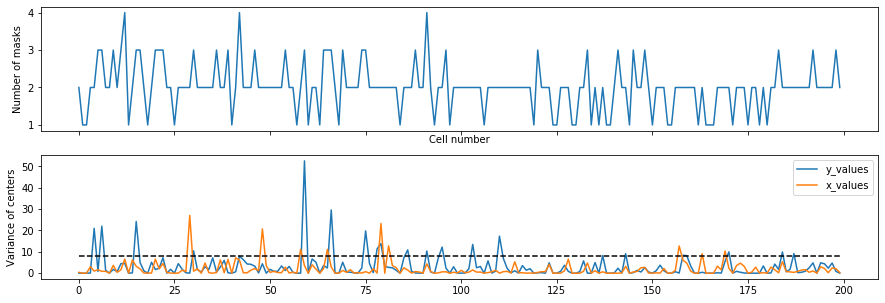

In [52]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [15, 5])
ax[0].plot(n_planes)
ax[0].set_xlabel('Cell number')
ax[0].set_ylabel('Number of masks')
ax[1].plot(var_masks[:, 0], label = 'y_values')
ax[1].plot(var_masks[:, 1], label = 'x_values')
ax[1].set_ylabel('Variance of centers')
ax[1].plot(range(len(indices)), np.ones(len(indices))*8, '--', color = 'k')
ax[1].legend()

In [54]:
ind = np.nonzero(var_masks > 30)[0]

In [55]:
ind

array([59], dtype=int64)

In [56]:
cell_no = ind[0] + 1
masks = Cell.cell_data[cell_no]['masks']
masks

{5: array([[ 355.71660459, 3172.90551683],
        [ 357.42504615, 3181.78941298],
        [ 365.28387736, 3189.30655587],
        [ 375.19283844, 3184.86460779],
        [ 376.21790338, 3176.32239996],
        [ 373.82608519, 3164.70499731],
        [ 369.38413712, 3159.92136093],
        [ 362.20868254, 3159.92136093],
        [ 361.1836176 , 3161.28811418]]),
 4: array([[ 364.94218905, 3173.58889346],
        [ 365.62556567, 3181.44772466],
        [ 370.06751374, 3188.96486755],
        [ 376.21790338, 3187.93980261],
        [ 377.92634495, 3179.05590647],
        [ 377.24296832, 3173.58889346],
        [ 372.45933194, 3168.46356876],
        [ 369.0424488 , 3167.78019213],
        [ 369.0424488 , 3167.43850382]]),
 6: array([[ 348.88283832, 3170.51369864],
        [ 346.83270844, 3177.3474649 ],
        [ 352.64140977, 3183.15616623],
        [ 358.10842278, 3181.78941298],
        [ 358.79179941, 3177.3474649 ],
        [ 356.74166953, 3171.53876358],
        [ 356.74166953, 317

In [120]:
Cell.cell_data.pop(cell_no)

{'cell_id': 30,
 'z_planes': [16, 17, 15],
 'masks': {16: array([[1080.85613872,  561.65899275],
         [1077.43598525,  561.45780725],
         [1074.21701728,  562.26254925],
         [1072.80871879,  564.87796072],
         [1076.22887226,  568.70048519],
         [1079.64902573,  572.32182416],
         [1081.86206621,  574.33367914],
         [1084.67866318,  574.13249364],
         [1086.48933267,  571.71826766],
         [1087.49526016,  568.29811419],
         [1086.69051816,  565.48151722],
         [1086.08696167,  564.27440423],
         [1085.48340517,  563.26847674]]),
  17: array([[1083.87392119,  563.06729124],
         [1079.24665473,  562.66492024],
         [1074.01583178,  562.86610574],
         [1070.79686381,  565.88388821],
         [1069.99212181,  568.70048519],
         [1072.0039768 ,  572.92538065],
         [1076.83242875,  574.93723563],
         [1080.45376772,  575.13842113],
         [1083.47155019,  574.53486464],
         [1085.68459067,  572.925380

## View saved masks in new napari window

In [326]:
# Open image in napari viewer - each channel as a separate layer 
viewer2 = napari.Viewer()

viewer2.add_image(im_array2[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
indices = list(Cell.cell_data.keys())
viewer2.add_shapes(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)
mask_layer = viewer2.layers['Shapes']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

In [303]:
mask_layer.add()

{1: {'cell_id': 1,
  'z_planes': [1],
  'masks': {1: array([[1203.88111044,  337.39930311],
          [1200.28185564,  338.59905471],
          [1197.08251804,  342.39826811],
          [1195.68280784,  345.19768851],
          [1199.28206264,  347.79715031],
          [1203.08127604,  349.59677772],
          [1206.88048944,  350.39661212],
          [1209.47995124,  348.99690192],
          [1211.47953724,  346.59739871],
          [1211.27957864,  342.99814391],
          [1208.48015824,  339.19893051],
          [1207.68032384,  338.19913751]])},
  'no_planes': 1,
  'c_vals': array([0.])},
 2: {'cell_id': 2,
  'z_planes': [1, 2],
  'masks': {1: array([[1211.33317027,  392.72244235],
          [1208.9794914 ,  393.21279212],
          [1208.48914163,  394.87998132],
          [1208.88142144,  398.41049963],
          [1209.96019093,  401.64680808],
          [1211.72545008,  403.41206723],
          [1214.17719891,  404.39276676],
          [1216.92315759,  405.47153624],
          